# I'm Something of a Painter Myself



**Summary**
The script begins by importing necessary libraries and acknowledging the guidance from Kaggle and other sources. Data preprocessing involves loading image datasets, performing exploratory data analysis (EDA), and applying normalization techniques. Data augmentation is incorporated to enhance the model's robustness. The plan of analysis includes hyperparameter tuning, with details left for individual customization.

The chosen architecture is a CycleGAN, employing a UNET structure for the generator. Encoder and decoder layers are defined for both the generator and discriminator. The discriminator utilizes instance normalization, and the generator employs skip connections to address the vanishing gradient problem. The learner describes the rationale behind the chosen architecture, hyperparameter tuning, and compares multiple architectures.

The analysis section encompasses reasoning behind successful outcomes, explanations for model performance, and discussions on hyperparameter optimization. Troubleshooting steps are detailed, providing insights into the model's behavior.

Overall, the project demonstrates a systematic approach to GANs implementation, with attention to data preprocessing, model architecture, hyperparameter tuning, and insightful analysis of results. 


**EDA**
There are 300 Monet paintings to train for stile recognition, and 7028 photos to target the stile.



**Some result**

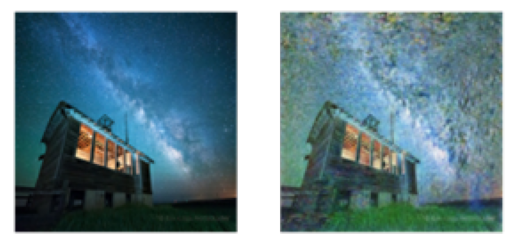

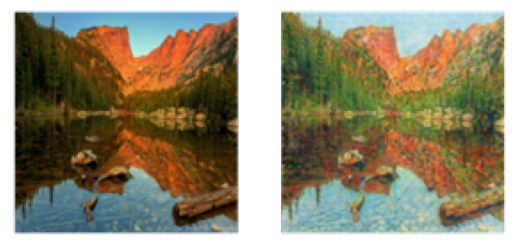

In [5]:
import matplotlib.pyplot as plt
from PIL import Image

plt.imshow(Image.open("example1.png"))
plt.axis('off') 
plt.show()
plt.imshow(Image.open("example2.png"))
plt.axis('off') 
plt.show()

**Code**

This notebook can be runned only on kaggle.

Notice that, following the guidance notebook provided by Kaggel, many libraries are deprecated.

I studied and learned form other solutions:
https://github.com/dimitreOliveira/MachineLearning

In [ ]:
import re
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import PIL


try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTO = tf.data.experimental.AUTOTUNE
print(tf.__version__)

In [ ]:

GCS_PATH = KaggleDatasets().get_gcs_path('gan-getting-started')
# GCS_PATH='//kaggle//input//gan-getting-started'

## Load in the data

We want to keep our photo dataset and our Monet dataset separate. First, load in the filenames of the TFRecords.

Added some exploratory data analysis.


In [ ]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))


# Exploration


def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

n_monet_samples = count_data_items(MONET_FILENAMES)
n_photo_samples = count_data_items(PHOTO_FILENAMES)




All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.

In [ ]:

BATCH_SIZE =  8 #4
EPOCHS_NUM = 30
IMAGE_SIZE = [256, 256]

OUTPUT_CHANNELS = 3

print("Monet TFRecord files: {MONET_LEN}".format(MONET_LEN=len(MONET_FILENAMES)))
print("Monet image files: {n_monet_samples}".format(n_monet_samples=n_monet_samples))

print("Photo TFRecord files: {PHOTO_LEN}".format(PHOTO_LEN=len(PHOTO_FILENAMES)))
print("Photo image files: {n_photo_samples}".format(n_photo_samples=n_photo_samples))

print("Batch_size: {BATCH_SIZE}".format(BATCH_SIZE=BATCH_SIZE))
print("Epochs number: {EPOCHS_NUM}".format(EPOCHS_NUM=EPOCHS_NUM))
print("Image size: {IMAGE_SIZE}".format(IMAGE_SIZE=IMAGE_SIZE))

In [ ]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

## Data augmentation

Added data augmentation to notebook

In [ ]:
def data_augment(image):
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    if p_crop > .5:
        image = tf.image.resize(image, [286, 286])
        image = tf.image.random_crop(image, size=[256, 256, 3])
        if p_crop > .9:
            image = tf.image.resize(image, [300, 300])
            image = tf.image.random_crop(image, size=[256, 256, 3])
    
    if p_rotate > .9:
        image = tf.image.rot90(image, k=3)
    elif p_rotate > .7:
        image = tf.image.rot90(image, k=2)
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=1)
        
    if p_spatial > .6:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        if p_spatial > .9:
            image = tf.image.transpose(image)
    
    return image

Define the function to extract the image from the files.

In [ ]:
def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

# Here modified the dataset loader

def get_gan_dataset(monet_files, photo_files, augment=None, repeat=True, shuffle=True, batch_size=1):

    monet_ds = load_dataset(monet_files)
    photo_ds = load_dataset(photo_files)
    
    monet_ds = monet_ds.map(augment, num_parallel_calls=AUTO)
    monet_ds = monet_ds.repeat()
    monet_ds = monet_ds.shuffle(2048)    
    monet_ds = monet_ds.batch(batch_size, drop_remainder=True)
    monet_ds = monet_ds.cache()
    monet_ds = monet_ds.prefetch(AUTO)
    
    photo_ds = photo_ds.map(augment, num_parallel_calls=AUTO)
    photo_ds = photo_ds.repeat()
    photo_ds = photo_ds.shuffle(2048)    
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)
    photo_ds = photo_ds.cache()
    photo_ds = photo_ds.prefetch(AUTO)
    
    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))
    
    return gan_ds

In [ ]:
def display_generated(b, gen, num_of_samples):
    b_iter = iter(b)
    for n_sample in range(num_of_samples):
        example_sample = next(b_iter)
        generated_sample = gen.predict(example_sample)
        
        plt.subplot(121)
        plt.title("Input image")
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        
        plt.subplot(122)
        plt.title("Generated image")
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()
        
    
def gen_pred_and_save(input_b, gen, output_path):
    i = 1 # for status
    for img in input_b:
        prediction = gen(img, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        im = PIL.Image.fromarray(prediction)
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1
        if i%50==0:
            print(i)
            print(round(i/7038,2))

In [ ]:
full_dataset = get_gan_dataset(MONET_FILENAMES, PHOTO_FILENAMES, augment=data_augment, repeat=True, shuffle=True, batch_size=BATCH_SIZE)

In [ ]:
example_monet , example_photo = next(iter(full_dataset))

Data exapmles after augmentions

In [ ]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

# Build the generator

We'll be using a UNET architecture for our CycleGAN. To build our generator, let's first define our `downsample` and `upsample` methods.

The `downsample`, as the name suggests, reduces the 2D dimensions, the width and height, of the image by the stride. The stride is the length of the step the filter takes. Since the stride is 2, the filter is applied to every other pixel, hence reducing the weight and height by 2.

We'll be using an instance normalization instead of batch normalization. As the instance normalization is not standard in the TensorFlow API, we'll use the layer from TensorFlow Add-ons.

(It's the downsampler)

In [ ]:
def EncoderLayer(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

(It's the upsampler)

In [ ]:
def DecoderLayer(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

Let's build our generator!

The generator first downsamples the input image and then upsample while establishing long skip connections. Skip connections are a way to help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers instead of only one. Here we concatenate the output of the downsample layer to the upsample layer in a symmetrical fashion.

In [ ]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    Encoder = [
        EncoderLayer(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        EncoderLayer(128, 4), # (bs, 64, 64, 128)
        EncoderLayer(256, 4), # (bs, 32, 32, 256)
        EncoderLayer(512, 4), # (bs, 16, 16, 512)
        EncoderLayer(512, 4), # (bs, 8, 8, 512)
        EncoderLayer(512, 4), # (bs, 4, 4, 512)
        EncoderLayer(512, 4), # (bs, 2, 2, 512)
        EncoderLayer(512, 4), # (bs, 1, 1, 512)
    ]

    Decoder = [
        DecoderLayer(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        DecoderLayer(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        DecoderLayer(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        DecoderLayer(512, 4), # (bs, 16, 16, 1024)
        DecoderLayer(256, 4), # (bs, 32, 32, 512)
        DecoderLayer(128, 4), # (bs, 64, 64, 256)
        DecoderLayer(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in Encoder:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and adding the skip connections
    for up, skip in zip(Decoder, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

tf.keras.utils.plot_model(Generator())


# Build the discriminator

The discriminator takes in the input image and classifies it as real or fake (generated). Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = EncoderLayer(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = EncoderLayer(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = EncoderLayer(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

tf.keras.utils.plot_model(Discriminator())


In [ ]:
with strategy.scope():
    monet_generator = Generator() # photos to Monet paintings
    photo_generator = Generator() # Monet paintings to photos

    monet_discriminator = Discriminator() # Monet paintings and generated paintings
    photo_discriminator = Discriminator() # real photos and generated photos

# Build the CycleGAN model

We will subclass a `tf.keras.Model` so that we can run `fit()` later to train our model. During the training step, the model transforms a photo to a Monet painting and then back to a photo. The difference between the original photo and the twice-transformed photo is the cycle-consistency loss. We want the original photo and the twice-transformed photo to be similar to one another.

The losses are defined in the next section.

In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)
            # monet to photo
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)
            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)
            # discriminator fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)
            
            # Losses
            # generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
            # total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            # total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)
        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply gradients - optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss,
            "cycle_loss":  total_cycle_loss
        }

# Define loss functions

The discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss.

In [ ]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

The generator wants to fool the discriminator into thinking the generated image is real. The perfect generator will have the discriminator output only 1s. Thus, it compares the generated image to a matrix of 1s to find the loss.

In [ ]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

We want our original photo and the twice transformed photo to be similar to one another. Thus, we can calculate the cycle consistency loss be finding the average of their difference.

In [ ]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return LAMBDA * loss1

The identity loss compares the image with its generator (i.e. photo with photo generator). If given a photo as input, we want it to generate the same image as the image was originally a photo. The identity loss compares the input with the output of the generator.

In [ ]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# Train the CycleGAN

Let's compile our model. Since we used `tf.keras.Model` to build our CycleGAN, we can just ude the `fit` function to train our model.

In [ ]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

**Training the Model**

In [ ]:
history = cycle_gan_model.fit(
                                full_dataset,
                                epochs=EPOCHS_NUM,
                                steps_per_epoch=(max(n_monet_samples, n_photo_samples)//BATCH_SIZE),
                            )

In [ ]:
monet_gen_loss = []
photo_gen_loss = []
monet_disc_loss = []
photo_disc_loss = []
total_cycle_loss = []

print(history.history.keys())
for epoc in range(EPOCHS_NUM):
    #print(history.history['monet_gen_loss'][epoc].shape)
    monet_gen_loss.append(np.average(history.history['monet_gen_loss'][epoc].flatten()))    
    photo_gen_loss.append(np.average(history.history['photo_gen_loss'][epoc].flatten()))
    monet_disc_loss.append(np.average(history.history['monet_disc_loss'][epoc].flatten()))
    photo_disc_loss.append(np.average(history.history['photo_disc_loss'][epoc].flatten()))
    total_cycle_loss.append(np.average(history.history['cycle_loss'][epoc]))



## Create submission file

In [ ]:
display_generated(load_dataset(PHOTO_FILENAMES).batch(1), monet_generator, 20)

In [ ]:
os.makedirs('../images/') # Create folder to save generated images
gen_pred_and_save(load_dataset(PHOTO_FILENAMES).batch(1), monet_generator, '../images/')

In [ ]:
shutil.make_archive('/kaggle/working/images/', 'zip', '../images')

print("Generated samples: {s}".format(s=len([name for name in os.listdir('../images/') if os.path.isfile(os.path.join('../images/', name))])))